In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [3]:
# split data into train and test set
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

In [13]:
# preprocessing - tokenization
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_token = "<OOV>"

x_train, y_train = train_df['headline'], train_df['is_sarcastic']
x_test, y_test = test_df['headline'], test_df['is_sarcastic']



tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

# Need this block to get it to work with TensorFlow 2.x
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
print(train_padded[0])

[ 539    1    5    1 1264 3957 1265   15 9259  129  435 5929    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [14]:
# create a simple model
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(24, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
optimizer = optimizers.Adam()
loss = losses.BinaryCrossentropy()
metrics=['accuracy']
model.compile(optimizer, loss, metrics)

In [22]:
# train
history = model.fit(train_padded, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
268/268 [==============================] - 2s 9ms/step - loss: 0.2625 - accuracy: 0.9004 - val_loss: 0.3283 - val_accuracy: 0.8596
Epoch 2/5
268/268 [==============================] - 2s 9ms/step - loss: 0.2351 - accuracy: 0.9099 - val_loss: 0.3182 - val_accuracy: 0.8652
Epoch 3/5
268/268 [==============================] - 2s 8ms/step - loss: 0.2127 - accuracy: 0.9208 - val_loss: 0.3374 - val_accuracy: 0.8524
Epoch 4/5
268/268 [==============================] - 2s 7ms/step - loss: 0.1952 - accuracy: 0.9272 - val_loss: 0.3176 - val_accuracy: 0.8687
Epoch 5/5
268/268 [==============================] - 3s 11ms/step - loss: 0.1779 - accuracy: 0.9337 - val_loss: 0.3220 - val_accuracy: 0.8687


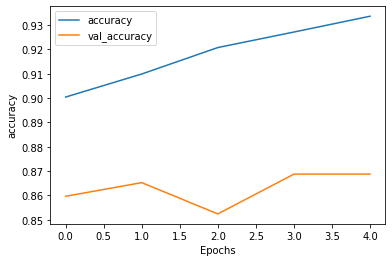

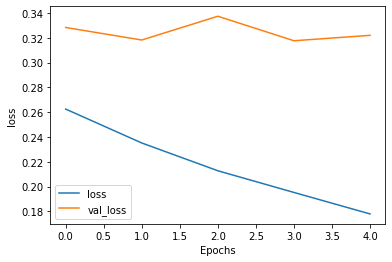

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
# evaluate the model
loss, acc = model.evaluate(test_padded, y_test, batch_size=64, verbose=0)
print(f'Loss is: {loss}, acc is: {acc}')

Loss is: 0.3388845920562744, acc is: 0.8607262969017029


In [29]:
# predict
sentences = ["It’s okay if you don’t like me. Not everyone has good taste.",
             "Today is a nice day."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
model.predict(padded)

array([[0.99081755],
       [0.0432575 ]], dtype=float32)